# RNNs para Martín Fierro

El objetivo de los ejercicios en este tutorial será mostrar el impacto de algunas decisiones de diseño en la implementación de las redes neuronales, particularmente las recurrentes. Como ejemplo veremos una implementación de la red **RNN** para generación de lenguaje basada en caracteres de [Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). Para entrenarla utilizaremos un fragmento del *Martín Fierro* que pueden descargar [aquí](https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/martin_fierro.txt). Para un entrenamiento más complejo, pueden utilizar las obras completas de *Borges*, disponibles en este [link](https://drive.google.com/file/d/0B4remi0ZCiqbUFpTS19pSmVFYkU/view?usp=sharing).

In [1]:
import numpy as np

import random
import sys

Primero leemos el dataset del archivo de texto y lo preprocesamos para disminuir la variación de caracteres. Normalizamos el formato *unicode*, eliminamos espacios, y transformamos todo a minúsculas.

In [2]:
import os
import wget

if not os.path.exists('martin_fierro.txt'):
    wget.download('https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/martin_fierro.txt')

In [3]:
import unicodedata
import re

with open('martin_fierro.txt', 'r') as finput:
    text = unicodedata.normalize('NFC', finput.read()).lower()
    text = re.sub('\s+', ' ', text).strip()

print(f'Full Corpus length: {len(text)}')

Full Corpus length: 33858


Luego contamos la cantidad de caracteres únicos presentes en el texto, asignando a cada uno un índice único y secuencial. Este índice será utilizado luego para crear las representaciones *one-hot encoding* de los caracteres.

In [4]:
chars = sorted(list(set(text)))

print(f'Chars total: {len(chars)}')

char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Chars total: 54


## Language Modeling

La tarea de *Language Modeling* (**LM**) es aprender $P_{\theta}$ parametrizada por $\theta$ para determinar $P_{\theta}(x|x_1,...x_t)$, donde $x$ puede ser un caracter o una palabra.

$LM(x, x_1, ..., x_t) = P_{\theta}(x | x_1,...x_t)$

Para la generación, la tarea de **LM** es ideal; dada una secuencia de entrada $x_1, ..., x_t$, podemos predecir la palabra de mayor probabilidad según nuestra probabilidad $P$.

$GenerationLM(x_1, ..., x_t) = max_{x} P_{\theta, x_1,...x_t}(x)$

Otra opción, sería sortear la siguiente palabra con respecto a la distribución generada, es decir, samplear $x \sim P_{\theta, x_1,...x_t}$.

## Parte 1: Esqueleto de la red neuronal

Lo primero que debemos pensar es cómo será la arquitectura de nuestra red para resolver la tarea deseada. En esta sección crearemos el modelo sequencial con *PyTorch* que representará nuestra red. En los pasos siguientes, implementaremos las transformaciones del corpus, por lo que en este paso pueden asumir cualquier formato en los datos de entrada.

In [5]:
import torch
import torch.nn as nn

# Check if we have a GPU available
use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if use_cuda else torch.device('cpu')

In [6]:
class MyModel(nn.Module):
    def __init__(self,
                 vocab_size,
                 input_size,
                 hidden_layer,
                 num_layers=1,
                 dropout=0,
                 bias=True,
                 bidirectional=False):

        super(MyModel, self).__init__()

        # Set the LSTM parameters
        self.lstm_config = {'input_size': input_size,
                            'hidden_size': hidden_layer,
                            'num_layers': num_layers,
                            'bias': bias,
                            'batch_first': True,
                            'dropout': dropout,
                            'bidirectional': bidirectional}

        # Set the FC layer parameters
        self.linear_config = {'in_features': hidden_layer,
                              'out_features': vocab_size,
                              'bias': bias}

        # Instanciate the layers
        self.encoder = nn.LSTM(**self.lstm_config)
        self.decoder = nn.Sequential()
        self.decoder.add_module('linear', nn.Linear(**self.linear_config))
        self.decoder.add_module('softmax', nn.LogSoftmax(dim=-1))

    def forward(self, inputs):
        outputs, _ = self.encoder(inputs)
        predictions = self.decoder(outputs)
        return predictions

In [7]:
model = MyModel(len(chars), len(chars), 128)

print(model)

MyModel(
  (encoder): LSTM(54, 128, batch_first=True)
  (decoder): Sequential(
    (linear): Linear(in_features=128, out_features=54, bias=True)
    (softmax): LogSoftmax(dim=-1)
  )
)


## Parte 2: Transformación del input

Una vez que definimos la arquitectura de la red, sabemos con exactitud cuál es el input que necesitamos utilizar. En esta sección transformaremos el texto que acabamos de leer del archivo, en ejemplos de entrenamiento para nuestra red. El resultado será una matriz que representa las secuencias de caracteres, y una matriz que representa las etiquetas correspondientes.

In [8]:
from torch.utils.data import Dataset, DataLoader

In [9]:
class MartinFierroDataset(Dataset):
    def __init__(self, text_data, max_len):

        self.max_len = max_len

        # Cut the text in sequences of max_len characters
        sentences = []
        next_chars = []
        for i in range(0, len(text_data) - max_len - 1, max_len):
            sentences.append(text_data[i: i + max_len])
            next_chars.append(text_data[i + 1: i + 1 + max_len])
        self.length = len(sentences)
        # Char Sequence Matrix
        self.X = np.zeros((len(sentences), max_len, len(chars)), dtype=np.float32)
        # Next Sequence Matrix
        self.y = np.zeros((len(sentences), max_len), dtype=np.float32)
        for i, sentence in enumerate(sentences):
            for t, char in enumerate(sentence):
                self.X[i, t, char_indices[char]] = 1
                self.y[i, t] = char_indices[next_chars[i][t]]

        print(f'NB Sequences: {self.length}')

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        output = {'X': self.X[idx], 'y': self.y[idx]}
        return output

In [10]:
data = MartinFierroDataset(text, 50)

NB Sequences: 677


## Parte 3: Entrenamiento de la red

En esta sección entrenaremos nuestra red. Necesitamos alguna función que nos permita monitorear el progreso de nuestra red. Para eso vamos a imprimir una muestra del texto generado por la red cada cierta cantidad de *epochs*.

Utilizaremos dos funciones que toman una porción de texto aleatorio, y generan nuevos caracteres con el modelo dado.

In [11]:
def temperature_sample(preds, temperature=1.0):
    # Helper function to sample an index from a probability array
    temp_preds = np.asarray(preds[:, -1, :]).astype('float64') / temperature
    exp_preds = np.exp(temp_preds)
    new_probs = (exp_preds / np.sum(exp_preds)).squeeze()
    final_probs = np.random.multinomial(1, new_probs, 1)
    return np.argmax(final_probs)

def print_sample(model, device, max_len=50):
    with torch.no_grad():
        model.eval()
        sample_size = 200
        start_index = random.randint(0, len(text) - max_len - 1)

        for diversity in [0.2, 0.5, 1.0, 1.2]:
            print()
            print(f'----- diversity: {diversity}')

            sentence = text[start_index: start_index + max_len]
            # Ejemplo: sentence = 'el bien perdido'
            print(f'----- Generating with seed: "{sentence}"')
            sys.stdout.write(sentence)

            # Printing the sample
            for i in range(sample_size):
                x = np.zeros((1, max_len, len(chars)), dtype=np.float32)
                # Build the one-hot encoding for the sentence
                for t, char in enumerate(sentence):
                    x[0, t, char_indices[char]] = 1.

                input_tensor = torch.tensor(x).to(device)

                logprob_preds = model(input_tensor)
                next_index = temperature_sample(logprob_preds.cpu().numpy(), diversity)
                next_char = indices_char[next_index]

                sentence = sentence[1:] + next_char

                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()

### Entrenamiento

Primero configuramos los hiperparámetros de la red. En este momento determinamos lo siguiente:
-  *epochs*
-  *learning_rate*
-  *loss*
-  *optimizer*

También definimos los parámetros para `DataLoader`, clase que implementa un manejador del dataset que nos dividirá los datos en *batches* (y los distribuirá entre distintos nodos de cómputo, en caso de contar con multi GPU).

In [12]:
import torch.optim as optim

epochs = 30

learning_rate = 0.001

loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

dataloader_config = {'dataset': data,
                     'batch_size': 32,
                     'shuffle': True,
                     'num_workers': 0,
                     'pin_memory': use_cuda}

# Send the model to GPU if there is one available!
model.to(device)

MyModel(
  (encoder): LSTM(54, 128, batch_first=True)
  (decoder): Sequential(
    (linear): Linear(in_features=128, out_features=54, bias=True)
    (softmax): LogSoftmax(dim=-1)
  )
)

In [13]:
from time import time

historical_loss = torch.FloatTensor()

# Set the model on train mode
model.train()
for epoch in range(1, epochs + 1):
    loss = 0

    start = time()

    # Show samples every 10 epochs
    if epoch % 10 == 0:
        print_sample(model, device)
        model.train()

    train_loss = torch.FloatTensor().to(device)

    dataloader = DataLoader(**dataloader_config)
    for i_batch, sample in enumerate(dataloader):
        inputs, gt_out = sample['X'].to(device), sample['y'].to(device)
        preds = model(inputs)
        bs, seq_len, cat = preds.size()

        # preds: batch_size x max_seq_length x len(chars)
        # gt_out: batch_size x max_seq_length
        # NLLLoss expects inputs of the form:
        #   N x C x d1 x ... x dt for the input
        #   N x d1 x ... x dt for the targets
        # So we transform define N = batch_size x max_seq_length, and we keep C = len(chars)
        loss = loss_function(preds.view(bs * seq_len, -1),
                             gt_out.view(bs * seq_len).type(torch.long)).unsqueeze(0)

        # Set gradients to 0, backpropagate, make an optimization
        # Store the loss for logging purposes
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = torch.cat([train_loss, loss])

    print(f'Epoch {epoch}; Time {time() - start}; Training Loss {torch.mean(train_loss)}')
    with torch.no_grad():
        historical_loss = torch.cat([historical_loss, torch.mean(train_loss.cpu()).view(1)])

Epoch 1; Time 0.38123655319213867; Training Loss 3.6455066204071045
Epoch 2; Time 0.2764570713043213; Training Loss 3.0953731536865234
Epoch 3; Time 0.3348557949066162; Training Loss 3.0490431785583496
Epoch 4; Time 0.2771143913269043; Training Loss 3.0272369384765625
Epoch 5; Time 0.2523345947265625; Training Loss 2.9990553855895996
Epoch 6; Time 0.3093838691711426; Training Loss 2.9582245349884033
Epoch 7; Time 0.28656983375549316; Training Loss 2.8977787494659424
Epoch 8; Time 0.6824660301208496; Training Loss 2.8137571811676025
Epoch 9; Time 0.39475488662719727; Training Loss 2.7338688373565674

----- diversity: 0.2
----- Generating with seed: "r más malo que una fiera. ¡quién no sentirá lo mes"
r más malo que una fiera. ¡quién no sentirá lo mes la  o e  ae e  el e  a ee ae  a so ao  a la aa  oe o se  e ae la  a  o  a  ar a  e ee me  e aa aa  a ei ae pa aa  a a a a s s  an aa  e la  a ea ae aa a la aa a  e  a  e  e ee ae la  a la  a e e e  e

----- diversity: 0.5
----- Generating w

## Comprobaciones

Para asegurarnos que el modelo está efectivamente entrenando, podemos graficar la función de pérdida en el corpus de validación.

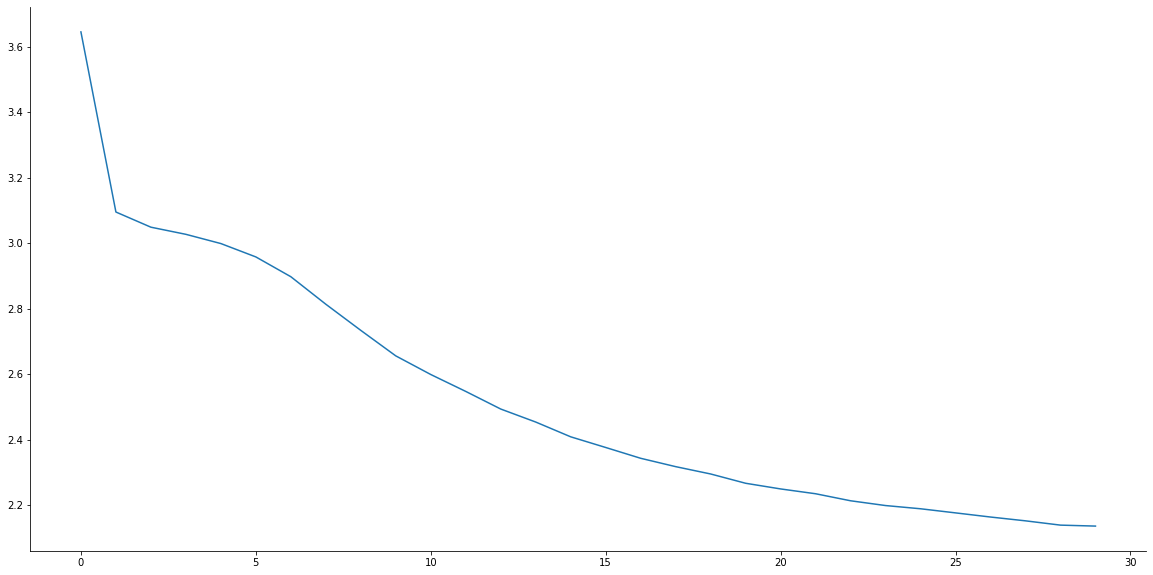

In [14]:
import matplotlib.pyplot as plt
import seaborn

plt.figure(figsize=(20, 10))

loss_values = historical_loss.detach().numpy()

seaborn.lineplot(x=range(loss_values.shape[0]), y=loss_values)

seaborn.despine()